# Imports

In [14]:
import numpy as np
from matplotlib import pyplot as plt
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from sklearn import svm
from sklearn.metrics import accuracy_score

# Download Dataset

In [3]:
file={"username":"mojtabanafez","key":"7c0ebd541704e0cb4357c05f78ed5fa2"}
import json
with open('kaggle.json', 'w') as fp:
    json.dump(file, fp)
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder

100% 1.83G/1.83G [00:14<00:00, 50.8MB/s]



In [ ]:
# !gdown --id 1-8UrAsreTpYezl2z58xdg8v6ab2BbYmu

In [5]:
!unzip -q /content/stanford-car-dataset-by-classes-folder.zip

# Create Generator

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

TRAIN_DATA_PATH = "./car_data/car_data/train"
TEST_DATA_PATH = "./car_data/car_data/test"

TRANSFORM_IMG =  transforms.Compose(
    [
      transforms.ToTensor(), 
      transforms.Resize(size=(224,224)),
     ])
BATCH_SIZE=32
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) 


In [8]:
len(train_data_loader), len(test_data_loader)

(255, 252)

In [7]:
dl=iter(train_data_loader)
x, y= next(dl)
x.shape, y.shape, torch.mean(x), torch.min(x), torch.max(x)

(torch.Size([32, 3, 224, 224]),
 torch.Size([32]),
 tensor(0.4739),
 tensor(0.),
 tensor(1.))

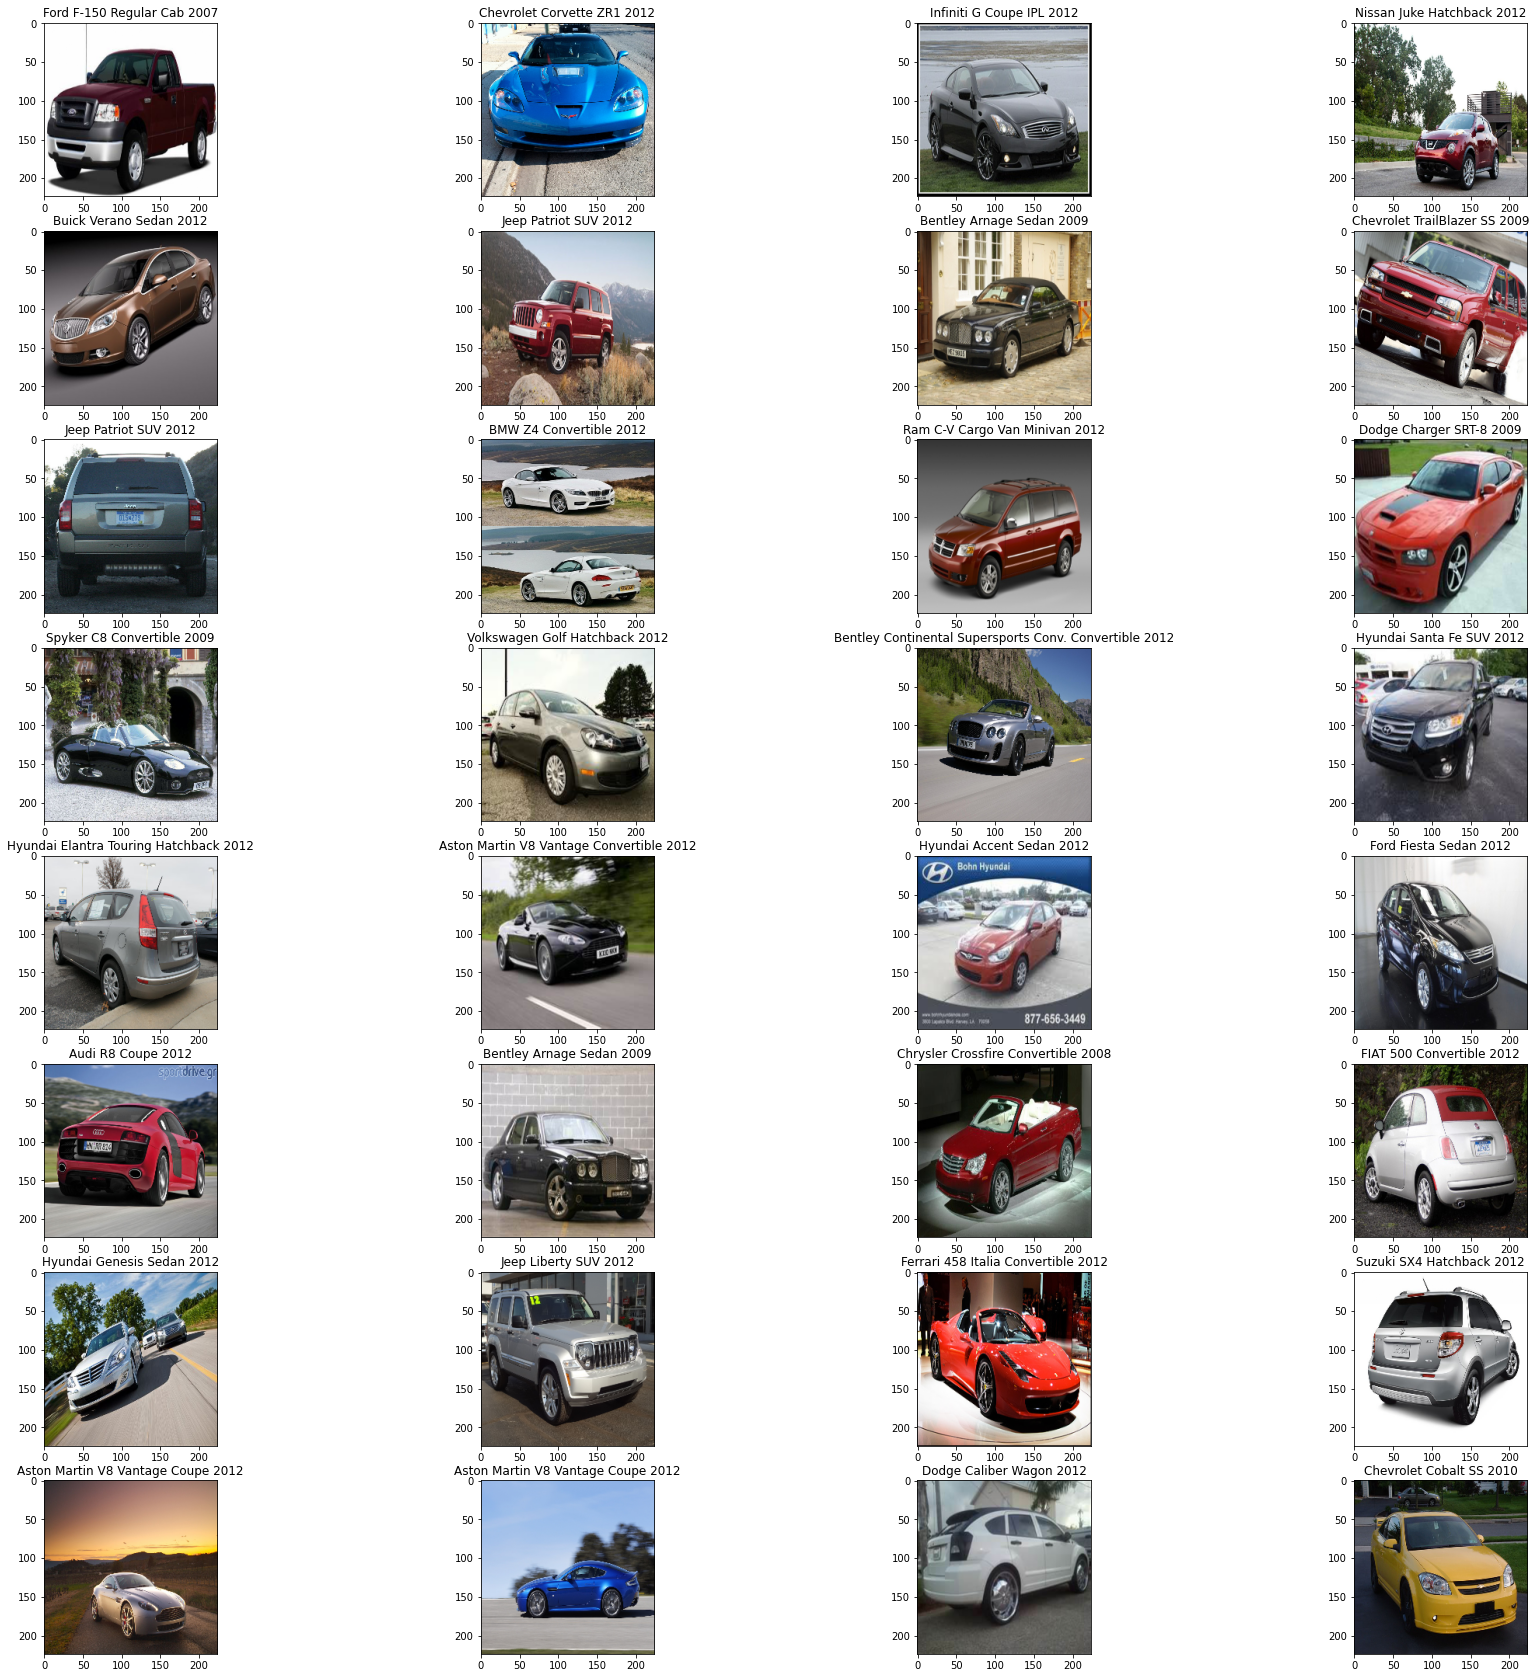

In [9]:
import numpy as np

classes = list(train_data.class_to_idx)


test_loader=iter(test_data_loader)
image, labels = test_loader.next()
image=np.array(image)
nrows=8
ncols=4
plt.figure (figsize = (30, 30))
image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 1, 2))
for i in range(image.shape[0]):
    sp = plt.subplot(nrows, ncols, i+1)
    plt.imshow(image[i])
    plt.title(classes[int(labels[i])])
plt.show()
# print(image.shape, np.mean(image), np.max(image), np.min(image))

In [31]:
dataloaders={
    'train':train_data_loader,
    'val': test_data_loader
}
dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'val']}

def save_checkpoint (state, filename):
    """ saving model's weights """
    print ('=> saving checkpoint')
    torch.save (state, filename)


def load_checkpoint (checkpoint, model):
    """ loading model's weights """
    print ('=> loading checkpoint')
    model.load_state_dict (checkpoint ['state_dict'])


def train_model(model, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    clf = svm.SVC()
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # We need to zero the gradients, don't forget it
                features = []

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                # SOME CHANGES SHOULD BE APPLIED HERE
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    for f in range(outputs.cpu().shape[0]):
                        features.append(np.array(outputs[f].cpu()))
                    # I WILL USE SVM INSTEAD OF THE NORMAL OPTIMIZER
                    if phase == 'train':
                        clf.fit(features, labels.cpu())

                preds = clf.predict(features)
                for i in range(outputs.cpu().shape[0]):
                    if preds[i] == labels[i].data:
                        current_corrects += 1


            epoch_acc = 100/32 * current_corrects/dataset_sizes[phase]

            print('{} Acc: {:.4f}'.format(
                phase, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model
dataset_sizes

{'train': 255, 'val': 252}

In [11]:
class ResnetModel(nn.Module):
    def __init__(self, original_model, num_classes):
        super(ResnetModel, self).__init__()

        # Everything except the last linear layer
        self.features = nn.Sequential(*list(original_model.children())[:-1])

    def forward(self, x):
        f = self.features(x)
        f = f.view(f.size(0), -1)
        return f

res_mod = models.resnet50(pretrained=True)
for p in res_mod.parameters():
    p.requires_grad = False

model = ResnetModel(res_mod, num_classes=len(classes))
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('pytorch_total_params= ', pytorch_total_params )
print('pytorch_total_trainable_params= ', pytorch_total_trainable_params)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

pytorch_total_params=  23508032
pytorch_total_trainable_params=  0


In [12]:
model

ResnetModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Changed
# params_to_update = []
# for name,param in model.named_parameters():
#     if param.requires_grad == True:
#         params_to_update.append(param)

model = model.to(device)
criterion = nn.CrossEntropyLoss() 

# Observe that all parameters are being optimized

# Decay LR by a factor of 0.1 every 7 epochs
base_model = train_model(model, num_epochs=10)


Epoch 0/9
----------
Iterating through data...
train Acc: 97.9779
Iterating through data...
val Acc: 0.5952

Epoch 1/9
----------
Iterating through data...
train Acc: 98.2108
Iterating through data...
val Acc: 0.5208

Epoch 2/9
----------
Iterating through data...
train Acc: 98.0147
Iterating through data...
val Acc: 0.5084

Epoch 3/9
----------
Iterating through data...
train Acc: 98.3456
Iterating through data...
val Acc: 0.9797

Epoch 4/9
----------
Iterating through data...
train Acc: 98.3333
Iterating through data...
val Acc: 0.7440

Epoch 5/9
----------
Iterating through data...
train Acc: 98.3578
Iterating through data...
val Acc: 2.1453

Epoch 6/9
----------
Iterating through data...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8316a8ec20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8316a8ec20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Acc: 98.3701
Iterating through data...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8316a8ec20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8316a8ec20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

val Acc: 0.4588

Epoch 7/9
----------
Iterating through data...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8316a8ec20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8316a8ec20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Acc: 98.2475
Iterating through data...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8316a8ec20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8316a8ec20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

val Acc: 0.5828

Epoch 8/9
----------
Iterating through data...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8316a8ec20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8316a8ec20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Acc: 98.1740
Iterating through data...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8316a8ec20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8316a8ec20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

val Acc: 0.9053

Epoch 9/9
----------
Iterating through data...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8316a8ec20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8316a8ec20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Acc: 98.1250
Iterating through data...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8316a8ec20>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8316a8ec20>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

val Acc: 0.5208

Training complete in 43m 17s
Best val Acc: 2.145337
